In [84]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from pathlib import Path
from cai_robustness_metrics.metrics.confidence_calibration import ConfidenceCalibration as ECE
from scipy.special import softmax
sns.set(color_codes=True)
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})
sns.set_palette("tab10")

WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


In [85]:
NAME = 'ResNet18'
EXP_ID = '11'
FILE = 'q_preds.csv'
TYPE = 'ECE' # ECE, CONFIDENCE

mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
df_runs = mlflow.search_runs(
    experiment_ids=EXP_ID,
    filter_string="tags.type = 'quantization'",
    output_format="pandas"
)

runs = df_runs[df_runs[AP] == '7']
# runs = df_runs

5


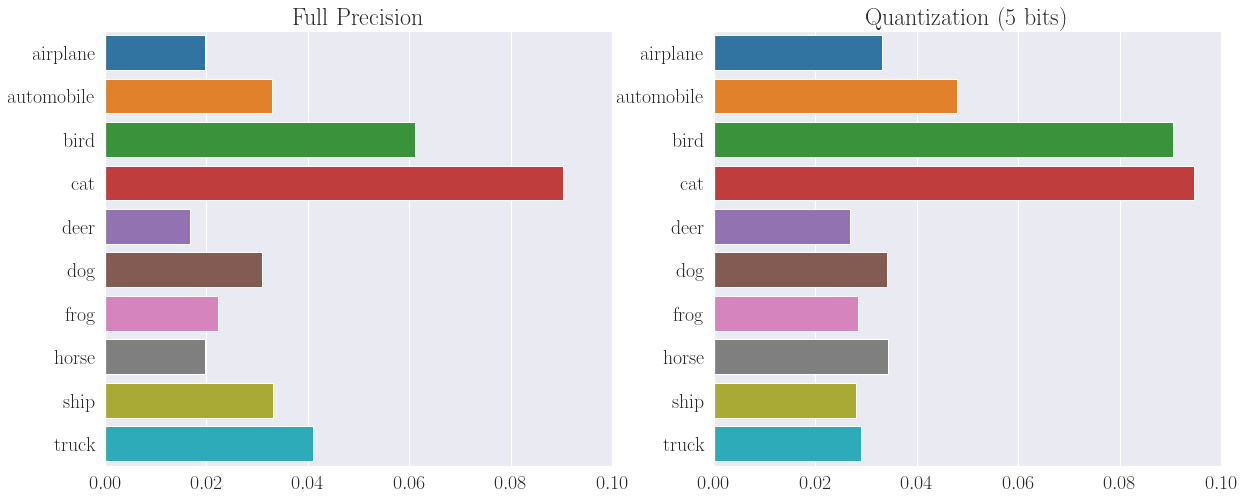

In [86]:
fp_run = mlflow.search_runs(
    experiment_ids="11",
    filter_string="tags.type = 'eval'",
    output_format="pandas"
).iloc[0]

fig, (ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2)


path = fp_run["params.csv_path"]
df = pd.read_csv(path + f"/preds.csv")

preds = df.iloc[:, 0:10].to_numpy()
preds = softmax(preds, axis=1)
targs = df['targets'].to_numpy()

ece = ECE(preds, targs, n_bins=10)
classece = ece.get_class_wise_ece()

ax1.set_title("Full Precision", fontsize=24)
ax2.set_title("Quantization (5 bits)", fontsize=24)
ax1.set_xlim(0, 0.1)
ax2.set_xlim(0, 0.1)

grid = sns.barplot(x=classece, y=labels, ax=ax1)
grid.tick_params(labelsize=20)


run = runs.iloc[3]
path = run["params.csv_path"]
ap = run[AP]
wp = run[WP]
print(wp)
df = pd.read_csv(path + f"/{FILE}")

preds = df.iloc[:, 0:10].to_numpy()
preds = softmax(preds, axis=1)
targs = df['targets'].to_numpy()

ece = ECE(preds, targs, n_bins=10)
classece = ece.get_class_wise_ece()

grid = sns.barplot(x=classece, y=labels, ax=ax2)
grid.tick_params(labelsize=20)

plt.savefig('/home/k.schwienbacher/quantization-robustness/data/ece/class_ece.pdf', bbox_inches="tight")

5


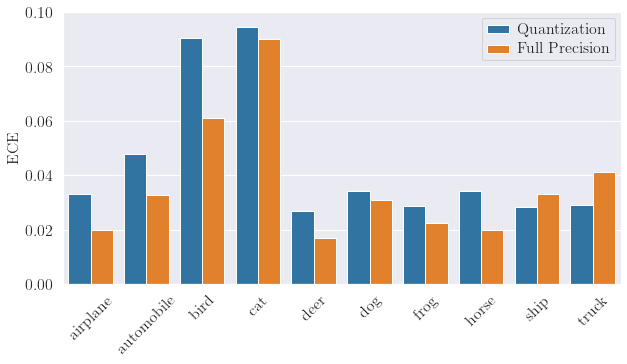

In [104]:
fp_run = mlflow.search_runs(
    experiment_ids="11",
    filter_string="tags.type = 'eval'",
    output_format="pandas"
).iloc[0]

path = fp_run["params.csv_path"]
df = pd.read_csv(path + f"/preds.csv")

preds = df.iloc[:, 0:10].to_numpy()
preds = softmax(preds, axis=1)
targs = df['targets'].to_numpy()

ece = ECE(preds, targs, n_bins=10)
fp_ece = ece.get_class_wise_ece()

run = runs.iloc[3]
path = run["params.csv_path"]
ap = run[AP]
wp = run[WP]
print(wp)
df = pd.read_csv(path + f"/{FILE}")

preds = df.iloc[:, 0:10].to_numpy()
preds = softmax(preds, axis=1)
targs = df['targets'].to_numpy()

ece = ECE(preds, targs, n_bins=10)
q_ece = ece.get_class_wise_ece()

results = []
for i in range(len(classece)):
    results.append({"ECE": q_ece[i], "model": "Quantization", "label": labels[i]})

    results.append({"ECE": fp_ece[i], "model": "Full Precision", "label": labels[i]})

df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(10, 5))
grid = sns.barplot(x="label", y="ECE", hue="model", data=df)
grid.tick_params(labelsize=16)
plt.xticks(rotation=45)
handles, labels2 = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels2[0:])
grid.legend(loc='upper right', ncol=1)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
grid.set_xlabel("", fontsize=14)
grid.set_ylabel("ECE", fontsize=16)
plt.ylim(0, 0.1)

plt.savefig('/home/k.schwienbacher/quantization-robustness/data/ece/class_ece.pdf', bbox_inches="tight")


<AxesSubplot:>

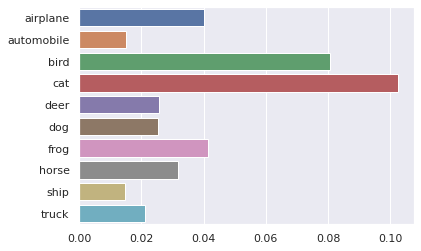

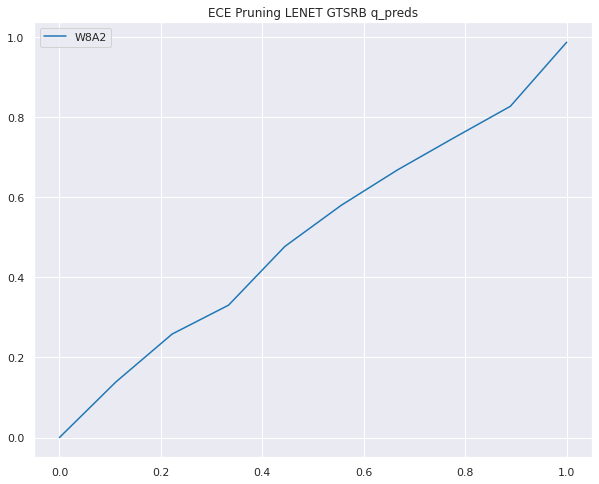

In [46]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")

run = runs.iloc[6]
path = run["params.csv_path"]
df = pd.read_csv(path + f"/{FILE}")


preds = df.iloc[:,0:10].to_numpy()
preds = softmax(preds, axis=1)
targs = df['targets'].to_numpy()

ece = ECE(preds, targs, n_bins=10)


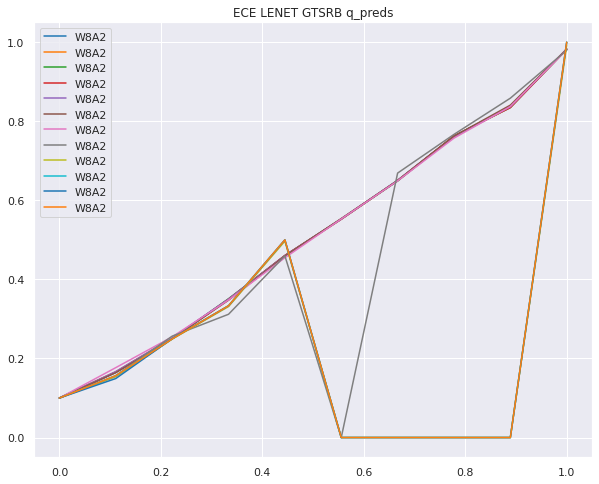

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
plt.title(f"{TYPE} {NAME} {FILE.removesuffix('.csv')}")

for i in range(len(runs)):
    run = runs.iloc[i]
    path = run["params.csv_path"]
    df = pd.read_csv(path + f"/{FILE}")

    preds = df.iloc[:,0:10].to_numpy()
    preds = softmax(preds, axis=1)
    targs = df['targets'].to_numpy()

    ece = ECE(preds, targs, n_bins=10)
    accuracies, mean_confidences = ece.get_calibration()

    if TYPE == 'ECE':
        sns.lineplot(x=np.linspace(0, 1, 10), y=mean_confidences, label=f"W{wp}A{ap}", markers=True)
    elif TYPE == 'CONFIDENCE':
        sns.lineplot(x=np.linspace(0, 1, 10), y=accuracies, label=f"W{wp}A{ap}")
    

#plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'g')
#plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/ece/{NAME}-{FILE.removesuffix('.csv')}A{ap}W{wp}.jpg")
